<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Levelized-Cost-of-Driving-Calculator" data-toc-modified-id="Levelized-Cost-of-Driving-Calculator-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Levelized Cost of Driving Calculator</a></span><ul class="toc-item"><li><span><a href="#Functions" data-toc-modified-id="Functions-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Functions</a></span></li><li><span><a href="#Setting-Inputs" data-toc-modified-id="Setting-Inputs-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Setting Inputs</a></span></li><li><span><a href="#-Calculations-and-Results-" data-toc-modified-id="-Calculations-and-Results--1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span> Calculations and Results </a></span></li><li><span><a href="#Data-Downloads" data-toc-modified-id="Data-Downloads-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Data Downloads</a></span></li></ul></li></ul></div>

<h1>Levelized Cost of Driving Calculator</h1>

The Purpose of this tool is to compare the levelized cost of driving (LCOD) for various types of vehilces based on assumptions made in the report *Canada's Energy Future 2018* published by the National Energy Board (NEB). LCOD is calculated by taking a number of variables into account including; the purchase price of a vehicle, fuel costs, the discount rate, and the expected life of the vehicle.

The following is based on work done by the National Renewable Energy Laboratory in their study *Electrification Futures Study:End-Use Electric Technology Cost and Performance Projections through 2050.*

Below is the script which pulls the data needed to make these calculations. Purchase and fuel cost data is taken from the NEB, while annual up keep cost assumptions are based on journal articles. 

In [3]:
#Import and clean data
import pandas as pd
pd.options.mode.chained_assignment = None 
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import seaborn as sns
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import Layout, Box
from textwrap import wrap

#Set current year
now = dt.datetime.now()
cur_year = now.year

#Import electricity data and gasoline data from EF, saved to local drive
end_use_data = pd.read_excel('C:\\Users\\saftryan\\English End Use Prices.xlsx') #Remap to local folder
elc_data = end_use_data[(end_use_data.Variable_English == 'Electricity') & (end_use_data.Sector == 'Residential') & (end_use_data.Case != 'High Price') & (end_use_data.Case != 'Low Price')]
elc_data['$/unit'] = elc_data['Value']/277.778
elc_data['Variable_English'] = 'B'
reg_gas = end_use_data[(end_use_data.Variable_English == 'Gasoline') & (end_use_data.Sector == 'Transportation') & (end_use_data.Case != 'High Price') & (end_use_data.Case != 'Low Price')]
reg_gas['$/unit'] = reg_gas['Value']*34.66/1000
reg_gas['Variable_English'] = 'X'
prm_gas = reg_gas.copy()
prm_gas['$/unit'] = prm_gas['$/unit']*1.1
prm_gas['Variable_English'] = 'Z'
diesel = end_use_data[(end_use_data.Variable_English == 'Diesel') & (end_use_data.Sector == 'Transportation') & (end_use_data.Case != 'High Price') & (end_use_data.Case != 'Low Price')]
diesel['$/unit'] = diesel['Value']*38.68/1000
diesel['Variable_English'] ='D'
neb_fuel = reg_gas.append(prm_gas)
neb_fuel = neb_fuel.append(diesel)
neb_fuel = neb_fuel.append(elc_data)

#Vehicle Costs
ef_costs = pd.read_excel('C:\\Users\\saftryan\\LCOD stuff\\EF Veh Costs.xlsx')

<h2>Functions</h2>

- **sets:** creates a list of based on all of the unque values in a column
- **LCOD_calc:** calculates the Levilized Cost of Driving using the formula:

<br>
$$ LCOD = \frac {CRF * CC + M} {km/yr} + \frac {CAD/Unit}{km/Unit}$$


Where: 
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;CC = NPV of capital cost of the vehicle
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;M = Annual maintenance cost of the vehicle 
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;km/yr = expected kilometers driver per year 
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;CAD/Unit = Cost of one unit of fuel (kwh or l of gasoline) 
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Eff = Fuel efficency of vehicle in l or kw per km 
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;CRF = Capital Recovery Factor

$$ CRF = \frac {r*(1+r)^t} {(1+r)^t-1} $$

Where: 
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;r = Discount rate 
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;t = Time period

- **eff_gains:** projects future improvements in fuel economy using the formula:

$$ Eff_i = Eff_0*(1-Imp)^{(t_i - t_0)} $$
Where:
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Eff = Fuel efficency of vehicle in liters of gasoline or kilowatts of electricity per kilometer 
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;t = Time period
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Imp = Rate of improvment in percent per year


In [4]:
#Create a list of names
def sets (data):
    name_set=[]
    for name in data:
        if name not in name_set:
            name_set.append(name)
    return name_set

#Calculate LCOD
def lcod_calc (cap_cost, main, fuel_cost, fuel_eff):
    fuel_eff1=np.where((single_fuel['veh']=='ice_truck') | (single_fuel['veh']=='ev_truck'),fuel_eff*1.5,fuel_eff)
    main1=np.where((single_fuel['veh']=='ice_truck') | (single_fuel['veh']=='ev_truck'),main*1.5,main)
    lcod = (crf*(cap_cost+I)+main1)/kmyr + fuel_cost/(1/(fuel_eff1/100))
    return lcod

#Calculate Capital Cost with equal monthly payments
def cc_calc (pmt_yrs, per_fin, cc, interest):
    payments = []
    for i in range(1,(pmt_yrs+1)*12):
        year_cc1 = (interest/12)*(cc*per_fin)
        year_cc2 = 1-((1+(interest/12))**(0-pmt_yrs*12))
        year_cc = year_cc1/year_cc2
        payments.append(year_cc)
    cc_disc = sum(payments) + cc*(1-per_fin)
    return cc_disc
    
#Calculate LCOD
def lcod_calc1 (cap_cost, main, fuel_cost, fuel_eff):
    fuel_eff1=np.where((single_fuel['veh']=='ice_truck') | (single_fuel['veh']=='ev_truck'),fuel_eff*1.5,fuel_eff)
    main1=np.where((single_fuel['veh']=='ice_truck') | (single_fuel['veh']=='ev_truck'),main*1.5,main)
    lcod = pd.DataFrame((crf*(cap_cost+I)+main1)/kmyr + fuel_cost/(1/(fuel_eff1/100)), columns=['lcod'])
    lcod['lcodcc'] = ((crf*(cap_cost))/kmyr) 
    lcod['lcodi'] = (crf*(I))/kmyr
    lcod['lcodm'] = (main1)/kmyr
    lcod['lcodkm'] = fuel_cost/(1/(fuel_eff1/100))
    return lcod

#Calcualte the annual improvement in chenicle efficency
def eff_gains (start_eff, impv):
    eff_proj = pd.DataFrame(data = {'Year': range(2020,2041), 'improve_time': range(1,22)})
    eff_proj['eff'] = start_eff*(1-impv)**(eff_proj['Year']-2020)
    return eff_proj

#Function that returns itself
def f (z):
    return z

In [5]:
#Name management and set widgets
prov_names = sets(neb_fuel['Region']) 
prov_names.sort()
rgnsel = interactive(f, z=widgets.Dropdown(options=prov_names, description='Region', value='Canada'));
infYN = interactive(f, z=widgets.Dropdown(options=['Add EV Charging Station','No EV Charging Station'],
                                          description='Charging', value='No EV Charging Station'));

<h2>Setting Inputs</h2>

The following cell contains variables that can be manipulated by the user, although it is not necessary to make any changes. They are defined below:

- **r:** Discount rate, can be set to any value between 0 and 1. A higher number means less value will be placed on future expenses

- **t:** The expected life of the vehicle in years

- **kmyr:** Enter number of km per year you expect drive

- **user_car_cost:** If you want to specify a price in Canadian dollars for the ICE vehicle enter it here, otherwise a class average will be used

- **user_ev_cost:** If you want to specify a price in Canadian dollars for the EV vehicle enter it here, otherwise the cost of the base model will be used

- **ice_main:** Specify annual amount you expect to pay in  maintenance for an ICE vehicle in Canadian dollars. If unknown leave as default.

- **ev_main:** Specify annual amount you expect to pay in Canadian dollars maintenance for an EV in Canadian dollars. If unknown leave as default. 

- **ev_eff_2020:** The efficency at which an EV uses electricty while driving in 2020, measured in kwh/km

- **ice_ann_impv:** Rate of annual improvement in EV efficency. A value of 0.02 % means efficency improves by 2% each year

- **ice_eff_2020:** The efficency at which an ICE vehicle uses gasolin while driving in 2020, measured in l/km of gasoline

- **ice_ann_impv:** Rate of annual improvement in ICE vehicle efficency. A value of 0.02 % means efficency improves by 2% each year


After defining variables run the cell below.

In [11]:
#Define Variables
r=0.10
t=15
kmyr=20000
ice_main = 530
ev_main = 450
ev_eff_2020 = 20 
ev_ann_impv = 0.02
ice_eff_2020 = 7
ice_ann_impv = 0.01
I = 0

#Financing variables
i_rate = 0.05
yr_loan = 5
fin_percent = 0.05

#Calculate CRF based on inputs
crf = (r*(1+r)**t)/((1+r)**t-1)

<h2> Calculations and Results </h2>
This section preforms calculations based on the inputs from the above section and plots the results in charts

In [9]:
#This section calculates discounted present value fuel prices
fuels_disc = pd.DataFrame()
for fuel in ['X','B']:
    disc_fuel = neb_fuel[neb_fuel['Variable_English']==fuel]
    for region in prov_names:
        disc_fuela = disc_fuel[disc_fuel['Region']==region]
        for case in ['Reference','Technology']:
            disc_fuelb = disc_fuela[(disc_fuela['Case']==case)]   
            disc_fuelx = disc_fuelb.append(disc_fuelb.iloc[[-1]*(t+5)],sort=False)
            disc_fuelx = disc_fuelx[disc_fuelx['Year']==2040].reset_index()
            disc_fuelx['Year'] = 2040 + disc_fuelx.index + 1
            disc_fuelb = disc_fuelb.append(disc_fuelx,sort=False).drop(columns=['index'])
            for year in [2020,2030,2040]:    
                disc_fuel1 = disc_fuelb[(disc_fuelb['Year']>=year)&(disc_fuelb['Year']<year+t)]
                disc_fuel1['new_price'] = sum(disc_fuel1['$/unit']/(1+r)**(disc_fuel1['Year']-min(disc_fuel1['Year'])))/15
                fuels_disc=fuels_disc.append(disc_fuel1.iloc[0], sort=True)

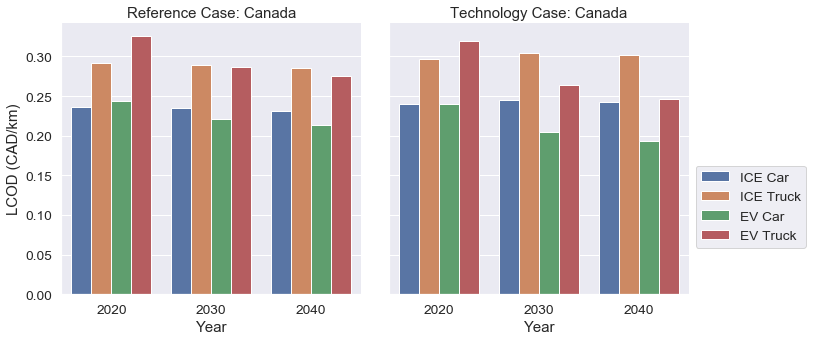

In [15]:
#Run the calculations based on your defined variables 
region ='Canada'
ev_eff_proj = eff_gains(ev_eff_2020, ev_ann_impv)
ev_eff_proj['Variable_English'] = 'B'
ice_eff_proj = eff_gains(ice_eff_2020, ice_ann_impv)
ice_eff_proj['Variable_English'] = 'X'
veh_eff_proj = ev_eff_proj.append(ice_eff_proj)

eff_merged = ef_costs.merge(fuels_disc, on=['Year', 'Variable_English', 'Case'])
eff_merged = eff_merged.merge(veh_eff_proj, on=['Year', 'Variable_English'])
eff_merged['cc_calc'] = cc_calc(yr_loan,fin_percent,eff_merged['price'],i_rate)

fuel_type_list = sets(eff_merged['Variable_English'])

eff_lcod=[]
for fuel_type in (fuel_type_list):
    if fuel_type == 'X':
        main = ice_main
    else:
        main = ev_main
    single_fuel = eff_merged[(eff_merged.Variable_English == fuel_type)]
    lcod_types = lcod_calc1(single_fuel['cc_calc'], main, single_fuel['new_price'], single_fuel['eff'])
    single_fuel1 = pd.concat([single_fuel,lcod_types], axis=1)
    single_fuel1 = pd.melt(single_fuel1, id_vars=['veh','Year','Variable_English','Case','Region'], 
                           value_vars=['lcod', 'lcodcc', 'lcodi','lcodm','lcodkm'])
    eff_lcod.append(single_fuel1)
veh_eff = pd.concat(eff_lcod)

#The line below can be activeate and the directory can be changed if you want to export the LCOD data to a csv file 
#veh_eff.to_csv('C:\\Users\\saftryan\\LCOD stuff\\lcod.csv')
rgn_plt = veh_eff[(veh_eff.Region == region) & (veh_eff.variable == 'lcod')]
#Plot Charts
sns.set(font_scale=1.25,)
g=sns.catplot(x='Year',y='value',hue='veh',data=rgn_plt, kind='bar',col='Case',ci=None, legend=False,
             row_order=['ice_car','ev_car', 'ice_truck','ev_truck'])
plt.legend(loc=0, labels = ['ICE Car', 'ICE Truck', 'EV Car', 'EV Truck'], bbox_to_anchor=(1,.5))
g.set_titles('{col_name} Case: '+ region)
g.set_axis_labels('Year','LCOD (CAD/km)')

The above charts show the projected LCOD in the region selected earlier based off of the vehicle cost assumptions made in the report *Canada's Energy Future 2018*.

The next section compares the difference in LCOD between an ICE and an EV in the Reference and Tecnology cases for the same sized vehicles (e.g. ICE Car vs EV Car) based off of the assumptions made in the previous section. To display charts showing these results run the cell below.

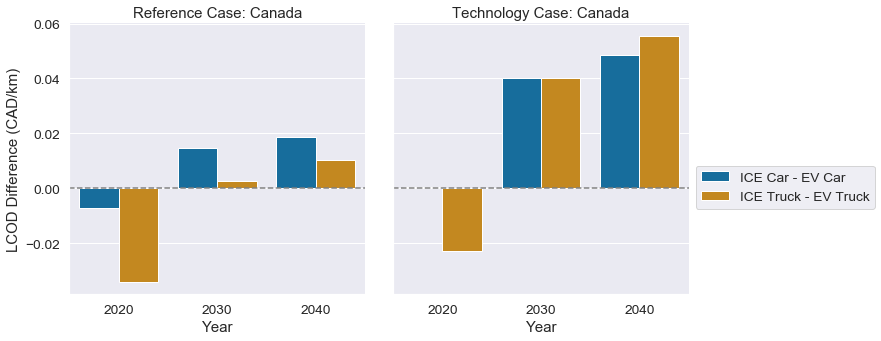

In [16]:
#Calculate differences in LCOD
ice_lcod = eff_lcod[0]
ev_lcod = eff_lcod[1]
ev_lcod = ev_lcod.reset_index(drop=True)
ice_lcod['ev_lcod'] = ev_lcod['value']
ice_lcod['comp_type'] = ice_lcod['veh'] + '-' + ev_lcod['veh']
ice_lcod['ice_less_ev'] = ice_lcod['value'] - ice_lcod['ev_lcod']
comp_list = sets(ice_lcod['comp_type'])
rgn_plt = ice_lcod[(ice_lcod.Region == region) & (ice_lcod.variable == 'lcod')]

sns.set(font_scale=1.25)
g=sns.catplot(x='Year',y='ice_less_ev',hue='comp_type',data=rgn_plt,
              kind='bar',col='Case',ci=None, legend=False, palette='colorblind')
g.set_axis_labels('Year','LCOD Difference (CAD/km)')
g.set_titles('{col_name} Case: '+ region)
ax1, ax2 = g.axes[0]
plt.legend(loc=0, labels = ['ICE Car - EV Car', 'ICE Truck - EV Truck'], bbox_to_anchor=(1,.5))
ax1.axhline(0, ls='--', color='grey')
ax2.axhline(0, ls='--', color='grey')

These charts show the difference in LCOD between ICE vehicles and EVs based off of the assumptions made earlier in the report. A positive number indicates that the electric version of either the car or truck has a lower LCOD than that of its ICE equivilant, meaning that is cheaper to drive on a per km basis. The point where EVs become cheaper than ICE vehicles will vary based on the imputs.

<h2>Data Downloads</h2>

In [172]:
#The lines below can be activeate and the directory can be changed if you want to export the LCOD data to a csv file 
veh_eff.to_csv('C:\\Users\\saftryan\\LCOD stuff\\lcod_feb21.csv')
ice_lcod.to_csv('C:\\Users\\saftryan\\LCOD stuff\\lcod_comp_feb21.csv')